In [1]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from google.colab import drive
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import requests
import tqdm as tqdm
import json
import os
import sys
import gc
import librosa



In [2]:
import pandas as pd
import numpy as np
import wave
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
from scipy.io.wavfile import write
from scipy import signal
from sklearn.model_selection import train_test_split
import librosa
import tqdm as tqdm
import random

In [3]:
def to_mel_spectrogram(spectrogram, sr, n_mels = 128):
    return librosa.feature.melspectrogram(y = None, sr=sr, S = spectrogram, n_mels=n_mels)


In [4]:
# Mount Google Drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Import custom functions
sys.path.append('/content/drive/My Drive/Colab Notebooks/final project/AudioNNRep/functions')
import functions as f

# Define the path to the data
path = '/content/drive/My Drive/Colab Notebooks/final project/audio/'

In [34]:
# Define the spectrogram to RGB conversion function
def spectrogram_to_rgb(spectrogram, eps=1e-6):
    # Min-max scale to fit inside 8-bit RGB
    img = 255 * (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + eps)
    # Convert to uint8
    img = img.astype(np.uint8)

    # Stack the image to create a 3-channel image
    img = np.stack([img] * 3, axis=-1)
    return img

# Load resnet18 model with pretrained weights
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.require_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 128),  # 512 for resnet18 or 2048 for resnet 50
        nn.ReLU(inplace=True),
        nn.Dropout(.2),
        nn.Linear(128, 6),
        nn.Sigmoid()
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    return model, optimizer

def loss_fn(y_pred, y_true):
    return torch.sum(torch.abs(y_pred - y_true)) / y_pred.shape[0]
def generate_mixed_spectrograms_time(n_mixed_spectrograms, number_of_instruments = 3, path = path):
    filenames = f.read_files_in_dir(path)
    organ = [filename for filename in filenames if "organ" in filename]
    bass = [filename for filename in filenames if "bass" in filename]
    guitar = [filename for filename in filenames if "guitar" in filename]
    vocal = [filename for filename in filenames if "vocal" in filename]
    flutes = [filename for filename in filenames if "flute" in filename]
    keyboards = [filename for filename in filenames if "keyboard" in filename]
    instruments = [organ, bass, guitar, vocal, flutes, keyboards]
    picked_inst_arr = np.zeros((n_mixed_spectrograms, len(instruments)))
    picked_inst_arr_1 = np.zeros((n_mixed_spectrograms, len(instruments)))

    for i in range(n_mixed_spectrograms):
        # Set 3 random values in picked_inst_arr to 1
        random_indices = np.random.choice(len(instruments), number_of_instruments, replace=False)
        random_indices_1 = np.random.choice(len(instruments), number_of_instruments, replace=False)
        for j in random_indices:
            picked_inst_arr[i, j] = 1
        for j in random_indices_1:
            picked_inst_arr_1[i, j] = 1

    mixed_spectograms = []
    mixed_spectograms_1 = []
    for i in tqdm.tqdm(range(n_mixed_spectrograms)):
        selected_files = []
        selected_files_1 = []
        # Select files from the picked instruments
        for j in range(len(instruments)):
            if picked_inst_arr[i, j] == 1:
                selected_files.append(random.choice(instruments[j]))
            if picked_inst_arr_1[i, j] == 1:
                selected_files_1.append(random.choice(instruments[j]))

        # Generate the mixed spectrogram, and save the individual spectrograms
        for j in range(len(selected_files)):
            waveform_test, sr = f.audio_to_waveform(path + selected_files[j])
            waveform_test_1, sr = f.audio_to_waveform(path + selected_files_1[j])

            if j == 0:
                combined_waveform = waveform_test
                combined_waveform_1 = waveform_test_1
            else:
                combined_waveform = combined_waveform + waveform_test
                combined_waveform_1 = combined_waveform_1 + waveform_test_1
        combined_waveform = np.concatenate((combined_waveform, combined_waveform_1))
        mixed_spectogram = f.waveform_to_spectrogram(combined_waveform)
        mixed_spectograms.append(mixed_spectogram)



    # Convert to numpy arrays
    mixed_spectograms = np.array(mixed_spectograms)
    picked_inst_arr = np.array(picked_inst_arr)
    picked_inst_arr_1 = np.array(picked_inst_arr_1)
    label = picked_inst_arr + picked_inst_arr_1
    # if label is higher 1.5 set it to 1
    label[label > 1.5] = 1

    return mixed_spectograms,  label

def plot_spectrogram_call(spectrogram, label):
    # Compute the STFT
    sr = 16000
    D_mag = spectrogram
    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(librosa.amplitude_to_db(D_mag, ref=np.max), sr=sr, x_axis='time', y_axis='log')
    #put the colorbar on the right
    plt.colorbar(format='%+2.0f dB')
    #put on the clas as title
    plt.title('Spektogram '+f'{label}')
    plt.show()


In [31]:
#run cell for time sequential plots
N_instruments = 5
X1, y1 = generate_mixed_spectrograms_time(N_instruments, 1, path=path)
X2, y2  = generate_mixed_spectrograms_time(N_instruments, 2, path=path)
X3, y3 = generate_mixed_spectrograms_time(N_instruments, 3, path=path)



# Add the data to a single test array
mixed_spectograms = np.concatenate((X1, X2, X3))


y_train_multi = np.concatenate((y1, y2, y3))


# Shuffle the data using numpy
shuffled_indices = np.random.permutation(len(y_train_multi))
mixed_spectograms = mixed_spectograms[shuffled_indices]
labels = y_train_multi[shuffled_indices]
gc.collect()

100%|██████████| 5/5 [00:38<00:00,  7.79s/it]


79021

In [43]:
labels[4]

array([1., 1., 1., 1., 1., 0.])

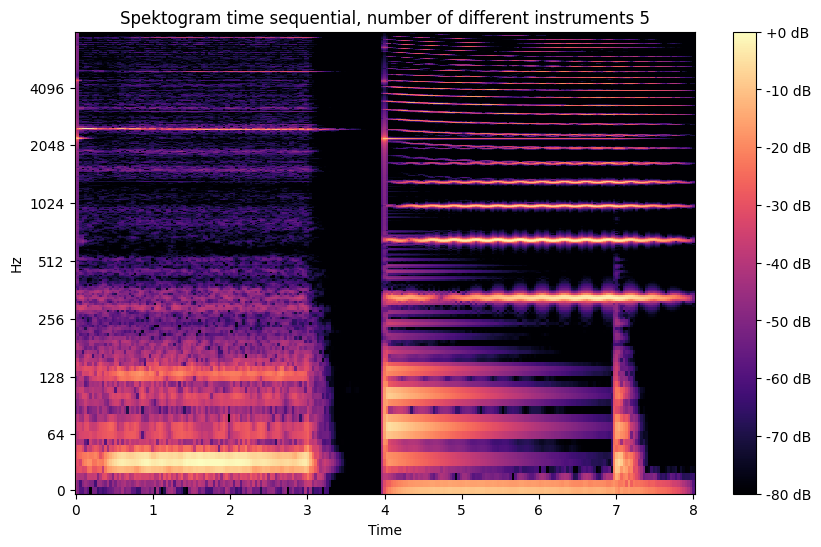

In [44]:
plot_spectrogram_call(mixed_spectograms[4], f'time sequential, number of different instruments 5')

In [ ]:
# For time independt model

#ixed_spectograms = to_mel_spectrogram(mixed_spectograms, 16000, n_mels = 128)

N_instruments = 1000
X1, y1 = f.generate_mixed_spectrograms(N_instruments, 1, path=path)
X2, y2 = f.generate_mixed_spectrograms(N_instruments, 2, path=path)
X3, y3 = f.generate_mixed_spectrograms(N_instruments, 3, path=path)
X4, y4 = f.generate_mixed_spectrograms(N_instruments, 4, path=path)
X5, y5 = f.generate_mixed_spectrograms(N_instruments, 5, path=path)
X6, y6 = f.generate_mixed_spectrograms(N_instruments, 6, path=path)

# Add the data to a single test array
mixed_spectograms = np.concatenate((X1, X2, X3, X4, X5, X6))

#mixed_spectograms = to_mel_spectrogram(mixed_spectograms, 16000, n_mels = 128), if you want to resize picture
y_train_multi = np.concatenate((y1, y2, y3, y4, y5, y6))

# Shuffle the data using numpy
shuffled_indices = np.random.permutation(len(y_train_multi))
mixed_spectograms = mixed_spectograms[shuffled_indices]
labels = y_train_multi[shuffled_indices]
gc.collect()


In [8]:
del X1, X2, X3, y1, y2, y3
gc.collect()

0

In [9]:
# Convert spectrograms to RGB
X_rgb = np.array([spectrogram_to_rgb(s) for s in mixed_spectograms])

del mixed_spectograms
gc.collect()

# Split into training, validation, and test sets (80/10/10)
X_train, X_val, X_test, y_train, y_val, y_test = f.split_data(X_rgb, labels, 0.1, 0.1)

del X_rgb
gc.collect()
# Convert numpy arrays to torch tensors and permute dimensions
X_train_rgb = torch.tensor(X_train).permute(0, 3, 1, 2).float()
del X_train
gc.collect()

y_train = torch.tensor(y_train).float()

X_val_rgb = torch.tensor(X_val).permute(0, 3, 1, 2).float()

del X_val
gc.collect()

y_val = torch.tensor(y_val).float()

X_test_rgb = torch.tensor(X_test).permute(0, 3, 1, 2).float()
del X_test
gc.collect()


y_test = torch.tensor(y_test).float()

# Scale the data to be between 0 and 1
def torch_min_max_normalization(X):
    X = (X - X.min()) / (X.max() - X.min())
    return X

X_train_rgb = torch_min_max_normalization(X_train_rgb)
X_val_rgb = torch_min_max_normalization(X_val_rgb)
X_test_rgb = torch_min_max_normalization(X_test_rgb)

# Create data loaders
batch_size = 16
train_dataset = TensorDataset(X_train_rgb, y_train)
val_dataset = TensorDataset(X_val_rgb, y_val)
test_dataset = TensorDataset(X_test_rgb, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)





In [10]:
del X_train_rgb, X_val_rgb, X_test_rgb
gc.collect()

0

In [11]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the model
model, optimizer = get_model()

gc.collect()
# Function to calculate accuracy
def get_accuracy(y_pred, y_true):
    y_pred = y_pred.detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy()
    y_pred = np.round(y_pred)
    accuracy = np.mean(y_pred == y_true)
    return accuracy

# Function to train the model
def train_model(model, train_loader, val_loader, optimizer, loss_fn, num_epochs=100, patience=5):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        epoch_train_acc = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                y_pred = model(x_batch.to(device))
                loss = loss_fn(y_pred, y_batch.to(device))
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_train_loss += loss.item()
            epoch_train_acc += get_accuracy(y_pred, y_batch)

        train_loss.append(epoch_train_loss / len(train_loader))
        train_acc.append(epoch_train_acc / len(train_loader))

        model.eval()
        epoch_val_loss = 0
        epoch_val_acc = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                y_pred = model(x_batch.to(device))
                loss = loss_fn(y_pred, y_batch.to(device))
                epoch_val_loss += loss.item()
                epoch_val_acc += get_accuracy(y_pred, y_batch)

        val_loss.append(epoch_val_loss / len(val_loader))
        val_acc.append(epoch_val_acc / len(val_loader))

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]}, Train Acc: {train_acc[-1]}, Val Loss: {val_loss[-1]}, Val Acc: {val_acc[-1]}")

        if epoch > patience and val_loss[-1] > min(val_loss[-patience:]):
            print("Early stopping due to no improvement in validation loss.")
            break

    return model, train_loss, train_acc, val_loss, val_acc

# Train the model
trained_model, train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, optimizer, loss_fn, num_epochs=100, patience=10)

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/100, Train Loss: 2.053103440205256, Train Acc: 0.7218055555555557, Val Loss: 1.4058110902183933, Val Acc: 0.8231907894736841
Epoch 2/100, Train Loss: 1.2345923189322154, Train Acc: 0.842083333333333, Val Loss: 1.0589433233988912, Val Acc: 0.8618421052631579
Epoch 3/100, Train Loss: 0.887354466120402, Train Acc: 0.8888194444444446, Val Loss: 0.7877833592264276, Val Acc: 0.9037828947368419
Epoch 4/100, Train Loss: 0.6722912112871806, Train Acc: 0.9191666666666665, Val Loss: 0.5839306116104126, Val Acc: 0.9273574561403509
Epoch 5/100, Train Loss: 0.5053214015563329, Train Acc: 0.9404861111111115, Val Loss: 0.5263653546571732, Val Acc: 0.9306469298245613
Epoch 6/100, Train Loss: 0.40697203516960145, Train Acc: 0.9519791666666665, Val Loss: 0.5837711668328235, Val Acc: 0.9141995614035084
Epoch 7/100, Train Loss: 0.3396567356586456, Train Acc: 0.9597569444444444, Val Loss: 0.397437857169854, Val Acc: 0.9435307017543857
Epoch 8/100, Train Loss: 0.2740668067956964, Train Acc: 0.9683680

In [12]:
with torch.no_grad():
  for x_batch, y_batch in val_loader:
    Y = model(x_batch.to(device))


In [ ]:
from torchviz import make_dot

In [ ]:
model_dir = '/content/drive/My Drive/Colab Notebooks/final project/AudioNNRep/'
model_file = 'audio_nn_model_sonic.pth.pth'

# Ensure the directory exists
os.makedirs(model_dir, exist_ok=True)

# Create the full path
model_path = os.path.join(model_dir, model_file)

# Save the model state dictionary
torch.save(model.state_dict(), model_path)

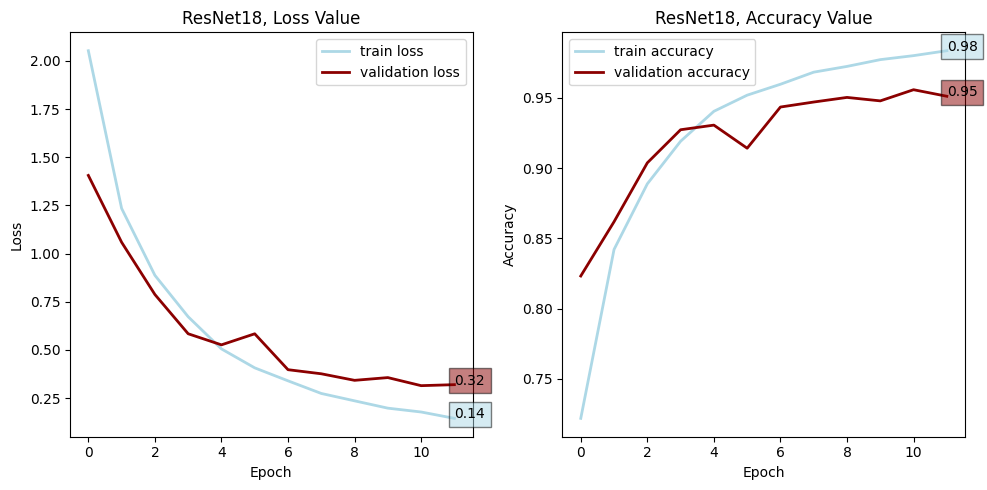

In [13]:

final_train_loss = train_loss[-1]
final_train_acc = train_acc[-1]
final_val_loss = val_loss[-1]
final_val_acc = val_acc[-1]

# Plotting with customization
plt.figure(figsize=(10, 5))

# Plot the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train loss', color='lightblue', linewidth=2)
plt.plot(val_loss, label='validation loss', color='darkred', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet18, Loss Value')
plt.legend()

# Annotate final values
plt.text(len(train_loss)-1, final_train_loss, f'{final_train_loss:.2f}', bbox=dict(facecolor='lightblue', alpha=0.5))
plt.text(len(val_loss)-1, final_val_loss, f'{final_val_loss:.2f}', bbox=dict(facecolor='darkred', alpha=0.5))

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train accuracy', color='lightblue', linewidth=2)
plt.plot(val_acc, label='validation accuracy', color='darkred', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet18, Accuracy Value')
plt.legend()

# Annotate final values
plt.text(len(train_acc)-1, final_train_acc, f'{final_train_acc:.2f}', bbox=dict(facecolor='lightblue', alpha=0.5))
plt.text(len(val_acc)-1, final_val_acc, f'{final_val_acc:.2f}', bbox=dict(facecolor='darkred', alpha=0.5))

plt.tight_layout()
plt.show()


In [ ]:
losslogger = [train_loss, val_loss]
epoch      = len(train_loss)

state = {'epoch': epoch + 1, 'state_dict': trained_model.state_dict(),
             'optimizer': optimizer.state_dict(), 'losslogger': losslogger}

torch.save(state, '/content/drive/My Drive/Colab Notebooks/final project/AudioNNRep/audio_nn_model_sonic_first.pth')

In [29]:
# Make predictions with the validation DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        all_predictions.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all predictions and labels into single arrays
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Print the shape of the predictions and labels
print("Predictions shape:", all_predictions.shape)
print("Labels shape:", all_labels.shape)


# Convert predictions to binary (0 or 1) if they are probabilities
all_predictions = np.round(all_predictions)

# Ensure all_labels are binary
all_labels = np.round(all_labels)

Predictions shape: (600, 6)
Labels shape: (600, 6)


Accuracy for organ: 0.9800
Accuracy for bass: 0.9433
Accuracy for guitar: 0.9017
Accuracy for vocal: 0.9983
Accuracy for flutes: 0.9833
Accuracy for keyboards: 0.9017
Accuracy for files with 1 instruments: 1.0000
Accuracy for files with 2 instruments: 0.9953
Accuracy for files with 3 instruments: 0.9528
Accuracy for files with 4 instruments: 0.9218
Accuracy for files with 5 instruments: 0.9071
Accuracy for files with 6 instruments: 0.9000


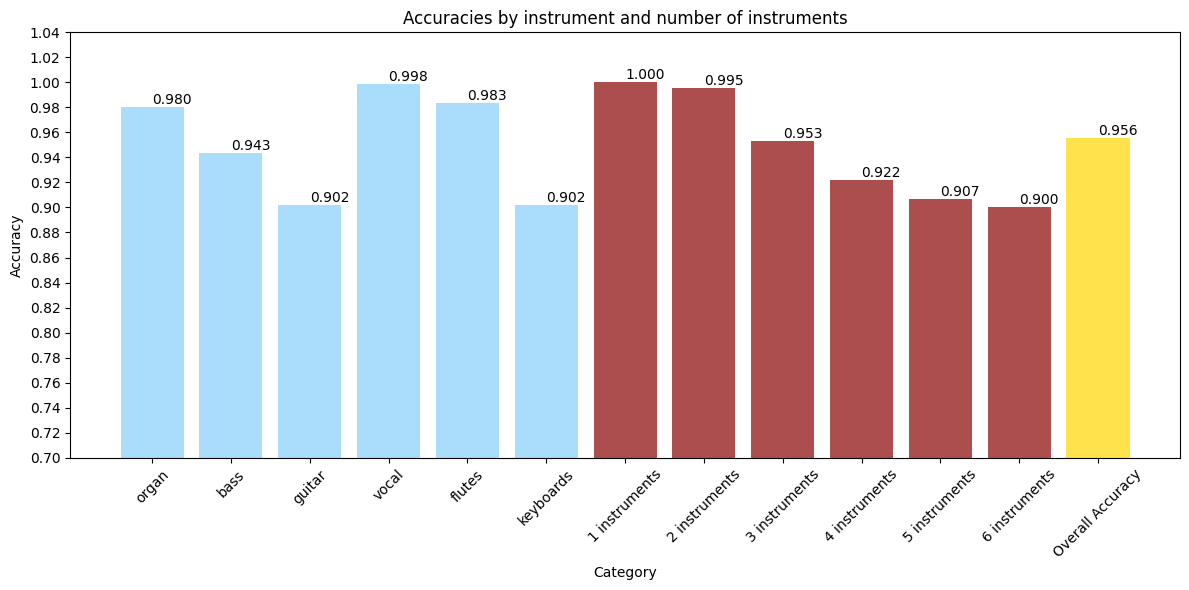

In [30]:
import numpy as np
import matplotlib.pyplot as plt
overall_accuracy = np.max(val_acc)

# Class names
instruments = ["organ", "bass", "guitar", "vocal", "flutes", "keyboards"]

# Initialize a dictionary to store the accuracy for each class
accuracies_instrument = {}

num_instruments = np.sum(all_labels, axis=1)

# Calculate accuracy for each class
for i, instrument in enumerate(instruments):
    correct_predictions = (all_predictions[:, i] == all_labels[:, i])
    accuracies_instrument[instrument] = correct_predictions.mean()

# Print the accuracy for each class
for instrument, accuracy in accuracies_instrument.items():
    print(f"Accuracy for {instrument}: {accuracy:.4f}")

# Assuming unique_instruments and num_instruments are defined
unique_instruments = np.unique(num_instruments)

accuracies_num = {}
for num in unique_instruments:
    indices = np.where(num_instruments == num)
    y_pred_subset = all_predictions[indices]
    y_true_subset = all_labels[indices]

    accuracy = (y_pred_subset == y_true_subset).mean()  # Simple accuracy calculation
    accuracies_num[num] = accuracy

# Print the accuracy for each category
for num, accuracy in accuracies_num.items():
    print(f"Accuracy for files with {int(num)} instruments: {accuracy:.4f}")

# Combine data for histogram
labels = list(accuracies_instrument.keys()) + [f"{int(num)} instruments" for num in unique_instruments] + ["Overall Accuracy"]
accuracies = list(accuracies_instrument.values()) + list(accuracies_num.values()) + [overall_accuracy]

# Define colors
colors = ['#87CEFA'] * len(accuracies_instrument) + ['#8A0303'] * len(accuracies_num) + ['#FFD700']

# Plotting the histogram
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, accuracies, alpha=0.7, color=colors)
plt.xlabel('Category')
plt.ylabel('Accuracy')
plt.title('Accuracies by instrument and number of instruments')
plt.xticks(rotation=45)

# Set y-axis limits and add extra ticks
plt.ylim(0.7, 1)
plt.yticks(np.arange(0.7, 1.05, 0.02))

# Adding value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', va='bottom')  # va: vertical alignment

plt.tight_layout()
plt.savefig('Accuracies_by_instrument_and_number_of_instruments.png')
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

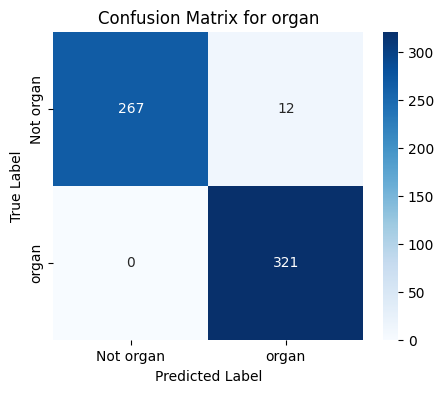

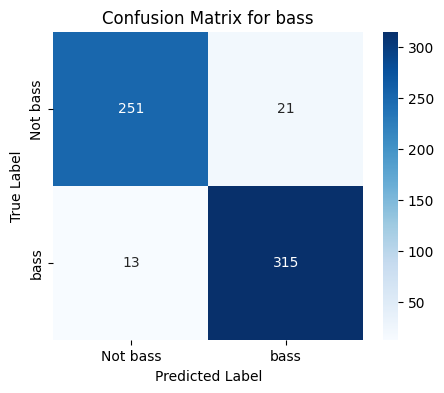

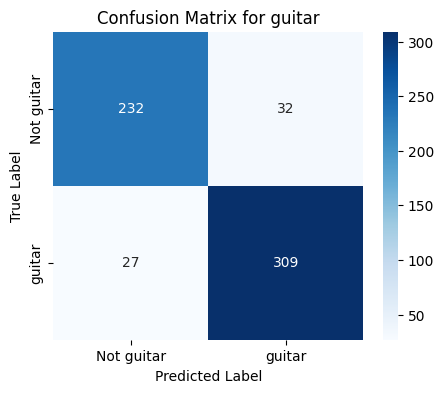

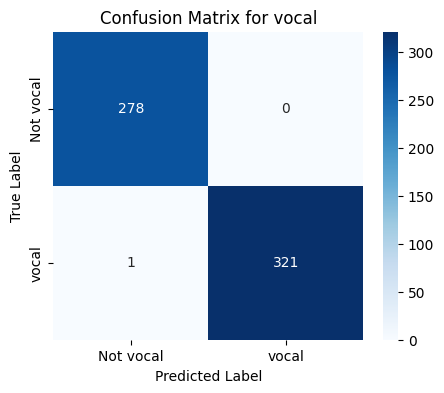

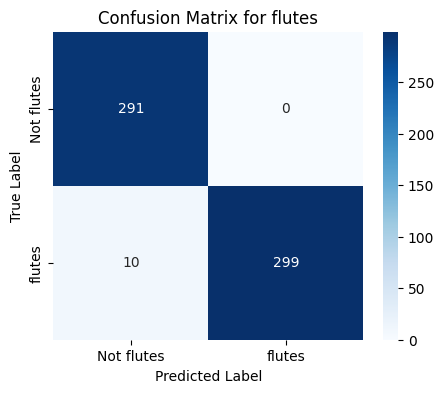

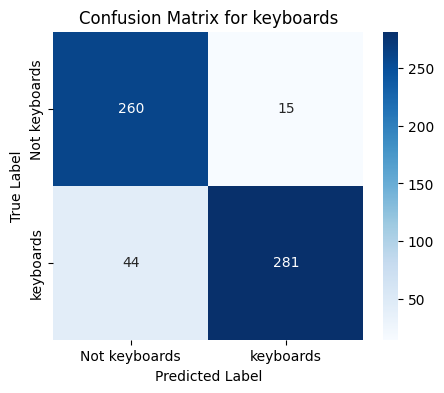

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


all_predictions = np.round(all_predictions)

# Ensure all_labels are binary
all_labels = np.round(all_labels)

# Class names
instruments = ["organ", "bass", "guitar", "vocal", "flutes", "keyboards"]

# Calculate and plot confusion matrix for each class
for i, instrument in enumerate(instruments):
    # Calculate confusion matrix for the current class
    cm = confusion_matrix(all_labels[:, i], all_predictions[:, i])

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Not {instrument}', instrument], yticklabels=[f'Not {instrument}', instrument])
    plt.title(f'Confusion Matrix for {instrument}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'confusion_matrix_{instrument}_first.png')
    plt.show()

